# Machine Learning Glossary 

> **Note:** Portions of this page are reproduced from work created and shared by Google and used according to terms described in the Creative Commons 4.0 Attribution License.

[Google for Developers](https://developers.google.com/terms/site-policies)

#### Libraries

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

## Parsing

In [ ]:
options = Options()
options.add_argument('--headless')
options.add_argument('--disable-gpu')
options.add_argument('--no-sandbox')

In [ ]:
driver = webdriver.Chrome(options=options)

In [ ]:
url = 'https://developers.google.com/machine-learning/glossary'
driver.get(url)

In [ ]:
try:
    element_present = EC.presence_of_element_located((By.CSS_SELECTOR, 'div.devsite-article-body'))
    WebDriverWait(driver, 10).until(element_present)
except Exception as e:
    print("Timed out waiting for page to load")
    driver.quit()
    raise

In [ ]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [ ]:
driver.quit()

In [ ]:
section = soup.find('div', class_='devsite-article-body')
headers = section.find_all('h2', class_='hide-from-toc')

#### Terms

In [ ]:
terms = []

for header in headers:
    header_id = header.get('id')
    data_text = header.get('data-text')
    terms.append(data_text.strip())

terms[:5]

['ablation', 'A/B testing', 'accelerator chip', 'accuracy', 'action']

In [62]:
len(terms)

605

In [63]:
token = 'grad'

[term for term in terms if token in term]

['exploding gradient problem',
 'gradient',
 'gradient accumulation',
 'gradient boosted (decision) trees (GBT)',
 'gradient boosting',
 'gradient clipping',
 'gradient descent',
 'mini-batch stochastic gradient descent',
 'stochastic gradient descent (SGD)',
 'vanishing gradient problem']

In [27]:
with open('data/terms.txt', 'w') as f:
    for term in terms:
        f.write("%s\n" % term) 

#### Glossary

In [ ]:
glossary = {}

for header in headers:
    data_text = header.get('data-text')
    description = []
    classes = []
    references = []

    sibling = header

    while True:
        sibling = sibling.find_next_sibling()
        if sibling is None or sibling.name == 'h2':
            break

        if sibling.name == 'div' and 'glossary-icon-container' in sibling.get('class', []):
            icon_div = sibling.find('div', class_='glossary-icon')
            if icon_div:
                class_data = icon_div.get('title', '').strip()
                if class_data:
                    classes.append(class_data)

        elif sibling.name == 'p' and sibling.get_text().strip() and not sibling.find('a', class_='glossary-anchor'):
            description.append(sibling.get_text().strip())
            references.extend([link.get_text().strip() for link in sibling.find_all('a') if link.get_text().strip()])

        elif sibling.name == 'ul':
            for li in sibling.find_all('li'):
                description.append(li.get_text().strip())
                references.extend([link.get_text().strip() for link in li.find_all('a') if link.get_text().strip()])

    glossary[data_text] = {
        'Description': ' '.join(description),
        'Classes': classes if classes else ['None'],
        'References': references if references else ['None']
    }

data = pd.DataFrame.from_dict(glossary, orient='index').reset_index()
data = data.rename(columns={'index': 'Term'})

data['Classes'] = data['Classes'].apply(', '.join)
data['References'] = data['References'].apply(', '.join)

#### Data

In [43]:
data.sample(3)

,Term,Description,Classes,References
484,sequence-to-sequence task,A task that converts an input sequence of toke...,Language Evaluation,tokens
217,ground truth,Reality. The thing that actually happened. For...,ML Fundamentals,binary classification
344,neural network,A model containing at least one\nhidden layer....,ML Fundamentals,"model, hidden layer, deep neural network, conv..."


In [44]:
data[['Classes']].value_counts()

Classes               
None                      185
ML Fundamentals           132
Language Evaluation        90
TensorFlow                 44
Fairness                   33
Decision Forests           31
Reinforcement Learning     27
Image Models               22
Sequence Models            13
Clustering                 12
Recommendation Systems     10
Generative AI               5
Google Cloud                1
Name: count, dtype: int64

In [ ]:
data.to_csv('./data/glossary.csv', index=False)

#### Graph

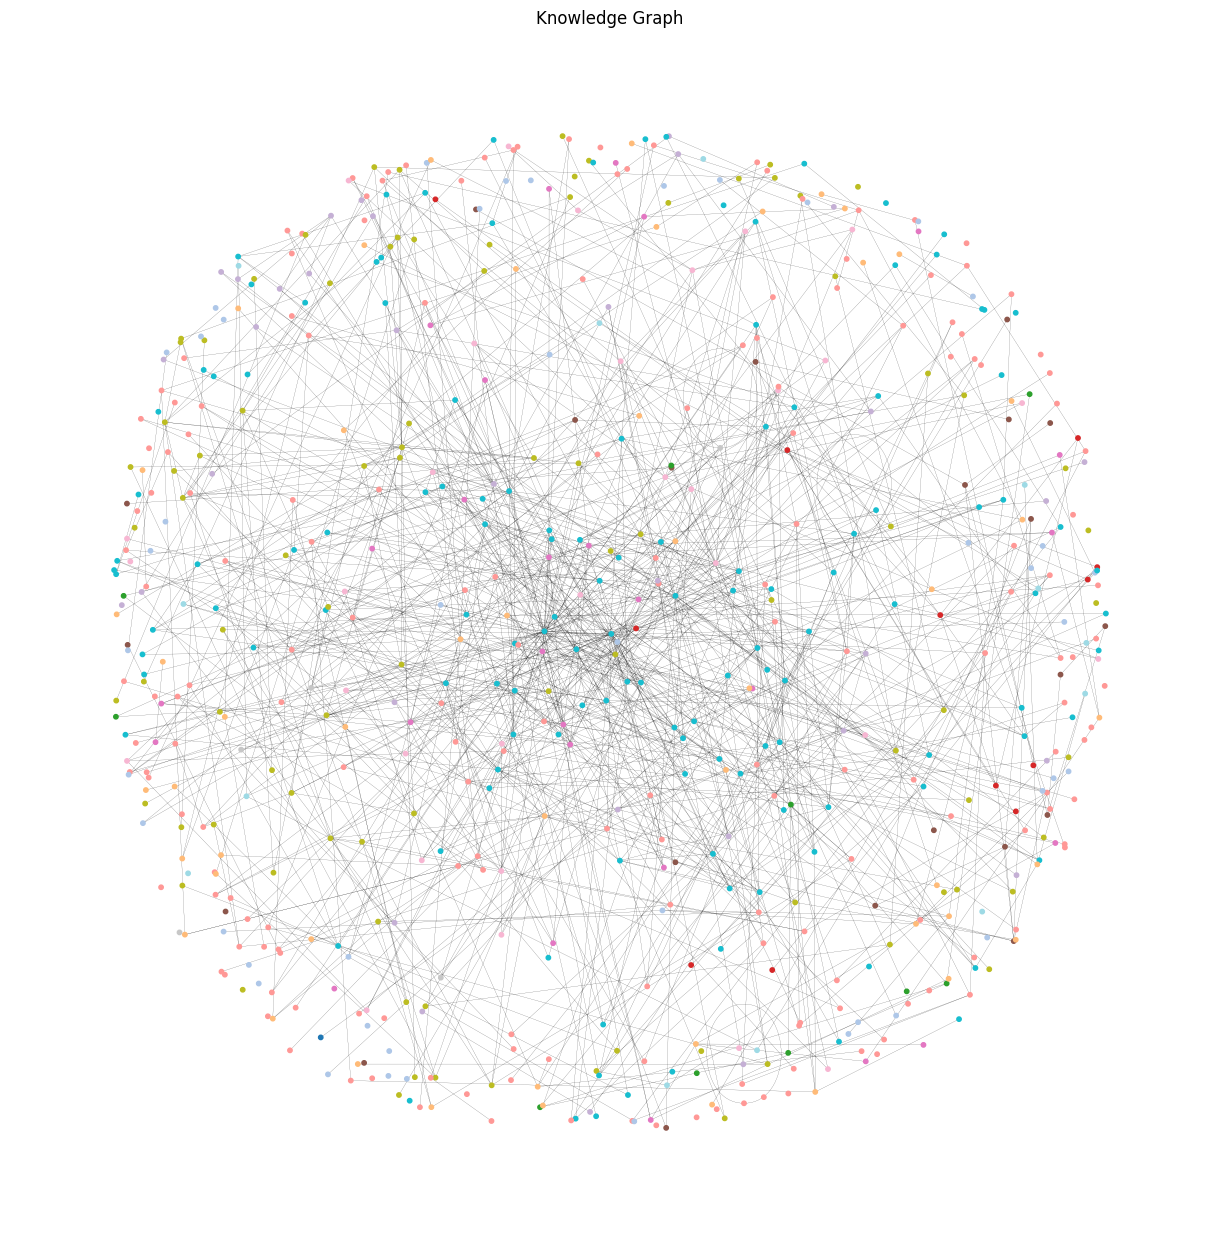

In [ ]:
def create_knowledge_graph(csv_file_path, filter_to_terms=True, visualize=False):
    try:
        df = pd.read_csv(csv_file_path, delimiter=',', encoding='utf-8')
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return

    df.columns = df.columns.str.strip().str.lower()

    if 'term' not in df.columns or 'references' not in df.columns:
        print("Error: 'Term' or 'References' column not found in CSV.")
        return

    G = nx.Graph()

    all_terms = set(df['term'].str.lower().str.strip())

    for _, row in df.iterrows():
        term = str(row['term']).strip()
        classes = str(row['classes']).strip() if 'classes' in df.columns else 'None'
        G.add_node(term, classes=classes)

    for _, row in df.iterrows():
        term = str(row['term']).strip()
        references = row['references']

        if pd.isna(references):
            continue

        refs = [ref.strip().lower() for ref in references.split(',')]
        for ref in refs:
            if not filter_to_terms or ref in all_terms:
                G.add_edge(term, ref)

    if visualize:
        unique_classes = set()
        for node in G.nodes:
            node_class = G.nodes[node].get('classes', 'None')
            main_class = node_class.split(',')[0].strip()
            unique_classes.add(main_class)

        base_cmap = plt.colormaps['tab20']
        cmap = base_cmap.resampled(len(unique_classes))

        class_list = list(unique_classes)
        color_map = {cls: mcolors.to_hex(cmap(i)) for i, cls in enumerate(class_list)}

        node_colors = []
        for node in G.nodes:
            node_class = G.nodes[node].get('classes', 'None')
            main_class = node_class.split(',')[0].strip()
            node_colors.append(color_map.get(main_class, 'gray'))

        plt.figure(figsize=(12, 12))
        pos = nx.spring_layout(G, k=0.5, seed=42)
        nx.draw(
            G,
            pos,
            node_size=10,
            node_color=node_colors,
            width=0.1,
            alpha=1,
            with_labels=False,
            font_size=8
        )
        plt.title("Knowledge Graph")
        plt.axis('off')
        plt.show()

    return G

csv_path = 'data/glossary.csv'

graph = create_knowledge_graph(csv_path, filter_to_terms=True, visualize=True)

In [ ]:
num_nodes = graph.number_of_nodes()
num_edges = graph.number_of_edges()
print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")


Number of nodes: 654
Number of edges: 958
